In [120]:
from ftplib import FTP
from astropy.table import Table
from astropy.time import Time
from astropy.io import fits

import requests
import os
import pandas as pd
import subprocess  
import glob
from datetime import datetime

from nicergof.utils import kp

In [6]:
DGDdir = 'resources/DGDfiles'
outfile = 'kpfiles/kp.fits'

# Use the kp.py functions to create the kp.fits file

In [7]:
stat = kp.mk_kp_fits(outfile=outfile, DGDdir = DGDdir)

Updating 2019Q2_DGD.txt
File = resources/DGDfiles/2018_DGD.txt
File = resources/DGDfiles/2019Q2_DGD.txt
File = resources/DGDfiles/2018Q1_DGD.txt
File = resources/DGDfiles/2018Q3_DGD.txt
File = resources/DGDfiles/2018Q2_DGD.txt
File = resources/DGDfiles/2019Q1_DGD.txt
File = resources/DGDfiles/2017_DGD.txt
File = resources/DGDfiles/2018Q4_DGD.txt
starting met calculation
Done MET calculation


0

In [8]:
kptab = Table.read(outfile,format='fits')

In [12]:
Time(kptab['MJD'].min(), format='mjd').iso, Time(kptab['MJD'].max(), format='mjd').iso


('2017-01-01 01:30:00.000', '2019-05-29 22:30:00.000')

# Development 

In [8]:
#
# get header template
#
hdu = fits.open('resources/kp.fits')
head = hdu[1].header


# Functions 

To create the KP.fits file

(Note: this work was started in the directory ``/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114``, for reference)

In [189]:
def mk_kp_fits(outfile ='kp_test.fits', header = None, 
               DGDdir = '/software/github/nicer/kcg/Notebooks/resources/DGDfiles',
               getdata=True, verbose=False, clobber=True,
               noaoftp="ftp.swpc.noaa.gov",noaoftpdir="/pub/indices/old_indices"):
    
    # assume everything will work
    status=0
    skipit = False
    
    # if getdata is True then download the data from the NOAO ftp site to the DGDdir
    if getdata:
        try:
            get_kp_data(DGDdir=DGDdir, noaoftp=noaoftp, noaoftpdir=noaoftpdir, verbose=verbose)
        except:
            status = "Error getting data from ftp://{0}/{1}".format(noaoftp, noaoftpdir)
            print(status)
            return status
    # read the data from each DGD file
    ## setup some lists and variable definitions

    MJD=[]
    KP = []
    kptime = ["T01:30:00",
              "T04:30:00",
              "T07:30:00",
              "T10:30:00",
              "T13:30:00",
              "T16:30:00",
              "T19:30:00",
              "T22:30:00"]
    counter = arange(0, 17, 2)
    
    ## get list of dgd files
    dgd = glob.glob(os.path.join(DGDdir,'*DGD*.txt'))
    if len(dgd) == 0:
        status = "No DGD files in {0}".format(DGDdir)
        skipit = True
    if not skipit:
        for d in dgd:
            fname = os.path.join(DGDdir,d)
            print("File = {0}".format(fname))
            with open(fname,'r') as f:
                for line in f:
                    if '20' in line[0:2]:
                        date=[]
                        kpval=[]
                        # parse line 
                        kpl=line[63:]
                        for i in counter[:-1]:
                            kpv = kpl[i:i+2].strip()
                            kpval.append(int(kpv))
                        newdate=line[0:10].replace(' ','-')
                        for kt in kptime:
                            t = "{date}{kt}".format(date=newdate, kt=kt)
                            date.append(Time(t,format='fits').mjd)
                        MJD.extend(date)
                        KP.extend(kpval)
        # sort by MJD
        iso = np.argsort(MJD)
        MJD = np.asarray(MJD)[iso]
        KP = np.asarray(KP)[iso]
        #
        # Create kp.fits file - TODO: calculate MET time from MJD
        #
        met = []
        #ind = arange(0,5).astype(int)
        print("starting met calculation")
        for i,m in enumerate(MJD):
            t = subprocess.run(['nicertimeconv','-met', Time(m,format='mjd').isot], text=True, capture_output=True).stdout
            met.append(float(t))
            #print(float(t), m, Time(m,format='mjd').isot)
        met=np.asarray(met)    
        print("Done MET calculation")
        #c1 = fits.Column(name='TIME', array=np.zeros(len(KP)), format='1D')
        c1 = fits.Column(name='TIME', array=met, format='1D')
        c2 = fits.Column(name='KP', array=KP, format='J')
        c3 = fits.Column(name='MJD', array=MJD, format='1D')
        # update header with CALDB keywords
        if header == None:
            header= fits.Header()
        calkeys={'TELESCOP':'NICER', 'INSTRUME':'XTI', 'DETNAM':'', 'FILTER':'',
                 'CCLS0001':'CPF','CCNM0001': 'KP_VALUES','CDTP0001':'DATA',
                 'CVSD0001':'2017-01-01','CVST0001':'00:00:00','CBD10001':'',
                 'CBD20001': '','CBD30001':'','CBD40001':'','CBD50001':'',
                 'CBD60001':'','CBD70001':'','CBD80001':'','CBD90001':'',
                 'CDES0001': 'Interplanetary KP values from NOAO'}
        for k in calkeys:
            header[k]=calkeys[k]
        header.add_comment('KP data from ftp://ftp.swpc.noaa.gov/pub/indices/old_indices')
        header.add_comment('FITS file created by mk_kp_fits()')
        header.add_comment('On {0} UT'.format(Time.now().isot))
        t = fits.BinTableHDU.from_columns([c1, c2, c3], header=header)
        try:
            t.writeto(outfile,output_verify='exception', overwrite=clobber, checksum=True)
        except Exception as e:
            status = "Error writing {0} ({1})".format(outfile, e)
            print(e)
    if status != 0:
        print(status)
    return status


def get_kp_data(DGDdir='/software/github/nicer/kcg/Notebooks/resources/DGDfiles',
                noaoftp="ftp.swpc.noaa.gov",noaoftpdir="/pub/indices/old_indices", 
                verbose=False):
    
    # get list of files and download them using wget
    dgddir = DGDdir

    # Get file list
    ftp = FTP(noaoftp)
    ftp.login()
    ftp.cwd(noaoftpdir)

    data = []
    ftp.dir(data.append)
    ftp.close()
    
    for d in data:
        if 'DGD' in d:
            test = d.split()[-1]
            if int(test[0:4]) >=2018:
                dgd.append(test)

    for d in dgd:
        fname = os.path.join(dgddir,d)
        # if file does not exist, get it
        if not os.path.isfile(fname):
            cmd = 'wget --output-document={0} ftp://{1}/{2}/{3}'.format(fname, noaoftp,noaoftpdir,d)
            if verbose:
                print(cmd)
            os.system(cmd)
        else:
            if verbose:
                print("{0} exists".format(fname))

    # update the most current file
    curfile = dgd[-1]
    print("Updating {0}".format(curfile))
    fname = os.path.join(dgddir,curfile)
    cmd = 'wget --output-document={0} ftp://{1}/{2}/{3}'.format(fname, noaoftp,noaoftpdir,d)
    if verbose:
        print(cmd)
    os.system(cmd)
 
    return 

In [190]:
head = mk_kp_fits(outfile ='kp_test1.fits', getdata=True, verbose=False)

Updating 2018Q4_DGD.txt
File = /software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q1_DGD.txt
File = /software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q3_DGD.txt
File = /software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q2_DGD.txt
File = /software/github/nicer/kcg/Notebooks/resources/DGDfiles/2017_DGD.txt
File = /software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q4_DGD.txt
starting met calculation
Done MET calculation


In [181]:
head = None
if head == None:
    head = fits.Header()
type(head)

astropy.io.fits.header.Header

## Compare kp_test.fits to resources/kp.fits

(array([ 540., 2079., 1559.,  886.,    0.,  411.,  150.,   38.,    6.,
           3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

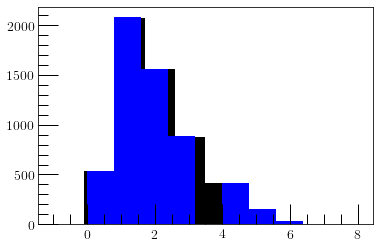

In [259]:
kp = fits.open('resources/kp.fits')
kptest = fits.open('kp_test1.fits')

hist(kptest[1].data.KP)
hist(kp[1].data.KP)

In [260]:
kptest[1].data.TIME[0],kptest[1].data.KP[0], kp[1].data.TIME[0],kp[1].data.KP[0]



(94699802.0, 4, 94699802.0, 4.0)

In [261]:
x2 = kp[1].data.TIME[-1]
x1 = kp[1].data.TIME[-100]

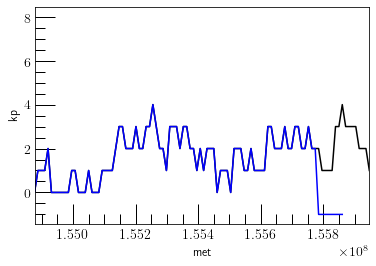

In [269]:
m = len(kptest[1].data.TIME)
xlim(x1, x2)
xlabel('met')
ylabel('kp')
plot(kp[1].data.TIME, kp[1].data.KP)
plot(kptest[1].data.TIME, kptest[1].data.KP)

#plot(kptest[1].data.TIME[:m], kptest[1].data.KP[:m])

In [266]:
len(kp[1].data.TIME)




5672

In [228]:
dkp = kp[1].data.KP-kptest[1].data.KP[:m]
ind = np.where(dkp != 0)[0]
Time(kptest[1].data.MJD[ind][0], format='mjd').isot, kptest[1].data.KP[ind][0]


('2018-09-27T07:30:00.000', 3)

In [246]:
a = list((ind-6))
a.extend(list(ind))
for i in a:
    print(kp[1].data.TIME[i],kp[1].data.KP[i],kptest[1].data.TIME[i],kptest[1].data.KP[i])

149434202.0 2.0 149434202.0 2
149445002.0 2.0 149445002.0 2
149455802.0 1.0 149455802.0 1
149488202.0 2.0 149488202.0 2
149499002.0 1.0 149499002.0 3
149509802.0 1.0 149509802.0 2
149520602.0 1.0 149520602.0 2
149553002.0 1.0 149553002.0 2


In [245]:
a = list((ind-6))
a.extend(list(ind))
print(a)

[5068, 5069, 5070, 5073, 5074, 5075, 5076, 5079]


In [134]:
kptest[1].header['CAL']

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =                 5656 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'TT      '           / Reference time system                          
TIMEZERO=                   0. / Time Zero                                      
TIMEUNIT= 's       '           / unit for time keywords                         
MJDREFI =                56658 / [d] MJD reference day (2014-01-01T00:00:00)    
MJDREFF = 0.0007775925925925

# Background: Creating the KP.fits file

the ``kp.fits`` file is created from the DGD.txt files stored on ftp://ftp.swpc.noaa.gov/pub/indices/old_indices 
KCG uses the script Build-KP-DATABASE.txt to download these data, extract the needed information, then create the ``kp.fits`` file

(Note: I've got KCG's script copied to /Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/Build-KP-DATABASE.txt)

We want to
* access the data from the noaa.gov ftp site
* parse the data using python
* create the ``kp.fits`` file
* run this as a cron job

The ``DGD.txt`` files are of the form

```
#                Middle Latitude        High Latitude            Estimated
#              - Fredericksburg -     ---- College ----      --- Planetary ---
#  Date        A     K-indices        A     K-indices        A     K-indices
2017 01 01     9  3 3 3 2 1 2 1 1    26  2 4 4 6 5 2 2 1    14  4 4 3 2 2 3 2 2
```

The columns needed are the ``Estimated Planetary K indices``.  Each day has 8 of them since they are reported every 3 hours. KCG uses the following 8 time assignments:

```
"T01:30:00"
"T04:30:00"
"T07:30:00"
"T10:30:00"
"T13:30:00"
"T16:30:00"
"T19:30:00"
"T22:30:00"
```



In [247]:
# get list of files and download them using wget

#dgddir = '/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/DGD_files'
DGDdir = '/software/github/nicer/kcg/Notebooks/resources/DGDfiles'

# Get file list
ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()
ftp.cwd('/pub/indices/old_indices')

data = []
ftp.dir(data.append)
ftp.close()

dgd=['2017_DGD.txt']


In [248]:
for d in data:
    if 'DGD' in d:
        test = d.split()[-1]
        if int(test[0:4]) >=2018:
            dgd.append(test)
            
# download the dgd files if necessary

In [249]:
for d in dgd:
    fname = os.path.join(DGDdir,d)
    # if file does not exist, get it
    if not os.path.isfile(fname):
        cmd = 'wget ftp://ftp.swpc.noaa.gov/pub/indices/old_indices/{0}'.format(d)
        print(cmd)
        os.system(cmd)
    else:
        print("{0} exists".format(fname))

# update the most current file
curfile = dgd[-1]
print("Updating {0}".format(curfile))
curfout = os.path.join(dgddir,curfile)
cmd = 'wget --output-document={0} ftp://ftp.swpc.noaa.gov/pub/indices/old_indices/{1}'.format(curfout, curfile)
print(cmd)
os.system(cmd) 

/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2017_DGD.txt exists
/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q1_DGD.txt exists
/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q2_DGD.txt exists
/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q3_DGD.txt exists
/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q4_DGD.txt exists
Updating 2018Q4_DGD.txt
wget --output-document=/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/DGD_files/2018Q4_DGD.txt ftp://ftp.swpc.noaa.gov/pub/indices/old_indices/2018Q4_DGD.txt


0

In [65]:
#dgddir = '/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/DGD_files'
fname = os.path.join(DGDdir,'2017_DGD.txt')
os.path.isfile(fname)

True

In [252]:
fname = os.path.join(DGDdir,'2018Q3_DGD.txt')
with open(fname,'r') as f:
    for line in f:
        if '20' in line[0:2]:
            print(line.strip())
        if '2018 09 27' in line:
            ltest = line

2018 07 01     4  1 1 1 2 2 1 1 1     0  1 0 0 0 0 0 0 0     3  0 1 1 1 1 0 0 1
2018 07 02     4  1 1 0 1 2 2 2 1     0  0 1 0 0 0 0 0 0     3  1 1 1 1 1 1 1 0
2018 07 03     5  1 1 0 2 2 2 2 1     2  0 0 0 0 1 2 1 1     4  0 1 1 1 1 2 1 1
2018 07 04     4  1 1 1 1 2 2 1 1     5  0 2 2 1 3 1 1 0     5  1 1 2 1 2 1 1 1
2018 07 05    11  2 1 0 2 3 3 4 3    13  2 1 1 2 4 4 3 3    17  2 1 1 2 3 4 5 4
2018 07 06     8  3 2 2 2 2 1 2 2     8  2 3 1 3 3 1 1 1     7  3 2 1 2 2 1 1 2
2018 07 07     6  2 2 1 2 2 2 2 1     4  2 2 2 1 1 1 1 0     5  2 2 1 2 1 1 2 0
2018 07 08     6  1 1 1 2 3 1 1 2     2  1 1 1 1 1 0 0 1     4  1 1 1 1 1 1 1 1
2018 07 09     5  1 1 1 1-1 2 2 2     1  1 1 0 0 0 0 0 0     3  1 1 0 1 0 0 0 1
2018 07 10    11  2 3 3 2 3 2 3 1     6  2 2 2 3 2 1 0 0     7  2 2 2 2 2 1 1 1
2018 07 11     8  0 2 2 2 3 3 2 2    12  0 1 2 5 4 1 1 1     8  0 2 3 3 3 2 2 2
2018 07 12     8  1 2 3 2 2 2 2 2    10  1 1 4 3 3 1 1 2     8  1 3 3 2 2 2 2 2
2018 07 13     6  2 2 2 2 1 2 1 1     4 

In [258]:

kpl=ltest[63:].strip()
print(kpl)
counter = arange(0, 17, 2)
for i in counter[:-1]:
    print(kpl[i:i+2].strip())


2 2 3 2 2 1 1 2
2
2
3
2
2
1
1
2


In [251]:
print(line[63:])
print(line)

 1 3 0 1 1 0 2 2

2018 09 30     4  1 2 0 1 1 1 2 2     3  1 1 0 1 2 0 1 1    19  1 3 0 1 1 0 2 2



In [64]:
#DGDdir = '/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/DGD_files'
dgd = glob.glob(os.path.join(DGDdir,'*DGD*.txt'))
dgd

['/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q1_DGD.txt',
 '/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q3_DGD.txt',
 '/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q2_DGD.txt',
 '/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2017_DGD.txt',
 '/software/github/nicer/kcg/Notebooks/resources/DGDfiles/2018Q4_DGD.txt']

In [68]:
kptime = ["T01:30:00",
          "T04:30:00",
          "T07:30:00",
          "T10:30:00",
          "T13:30:00",
          "T16:30:00",
          "T19:30:00",
          "T22:30:00"]
newdate=line[0:10].replace(' ','-')
line, newdate

('2017 12 31     2  0 1 0 0 0 1 2 1     2  0 0 0 0 1 1 1 1     4  1 0 0 0 0 1 2 2\n',
 '2017-12-31')

In [71]:
t = "{date}{kt}".format(date=newdate, kt=kptime[0])
Time(t,format='fits').iso

'2017-12-31 01:30:00.000'

In [70]:
# the kp.fits file

hdu = fits.open('kp.fits')
hdu.info()
kp = hdu[1].data
(kp.TIME[1]- kp.TIME[0])/86400*24

Filename: kp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     23   5080R x 2C   [1D, 1D]   


3.0

In [254]:
kp[1].data.TIME[0]

94699802.0

In [19]:
#
# get header template
#
hdu = fits.open('kp.fits')
head = hdu[1].header
DGDdir = '/Users/corcoran/program/HEASARC/missions/NICER_HEASARC/bkg_script/20181114/DGD_files'

mk_kp_fits(outfile ='kp_test.fits', header = head, DGDdir=DGDdir)

0

In [21]:
ls -lt


total 200
-rw-r--r--+ 1 corcoran  staff   5760 Nov 20 17:07 kp_test.fits
-rw-r--r--+ 1 corcoran  staff  55681 Nov 20 17:05 Create_KP_file.ipynb
-rw-r--r--+ 1 corcoran  staff   4598 Nov 20 17:00 2018Q4_DGD.txt.1
-rw-r--r--+ 1 corcoran  staff   4278 Nov 16 15:08 2018Q4_DGD.txt
drwxr-xr-x+ 7 corcoran  staff    224 Nov 16 07:08 DGD_files/
lrwxr-xr-x  1 corcoran  staff     37 Nov 15 11:17 kp.fits@ -> /software/github/nicer/kcg/v7/kp.fits
drwxr-xr-x+ 3 corcoran  staff     96 Nov 15 11:10 tmp/
-rw-r--r--@ 1 corcoran  staff   7188 Nov 15 10:08 mkfwork_v1_optmv7_60deg.py
-rw-r--r--@ 1 corcoran  staff   1524 Nov 15 10:08 Make-Background-By-pha.txt
-rw-r--r--@ 1 corcoran  staff   4301 Nov 15 10:08 Build-KP-DATABASE.txt


In [22]:
kp=pyfits.open('kp_test.fits')


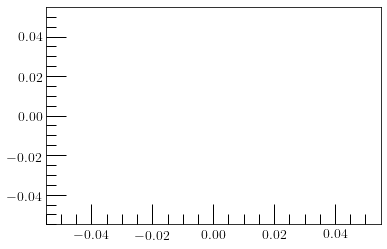

In [24]:
plot(kp[1].data.TIME, kp[1].data.KP,'.')

# Parsing the Potsdam Files

From Keith (July 15 2019)
```
The Potsdam site is:
ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/
 
The negatives of the site:
It is updated less regularly… monthly or more… ( at one point, I did not notice an update for several months…)
Difficult to parse…
 
The positives of the site:
Higher “KP” resolution:  “0+”=0.3333 “1-“ = 0.6666, “1o”=1.0, etc…
In principle, more accurate as it averages a large collection of data than the NOAA site
```

In [68]:
# potsdam ftp archive - definitive data
pkpftp = "ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/"
# downloaded data from the ftp archive - definitive
pkpdir = '/software/github/nicergof/utils/refdata/potsdam'
# list of definitive files
pkpfiles = glob.glob(f"{pkpdir}/kp*tab")
# "definitive" KP file from KCG
kpkcg = '/software/github/nicergof/utils/refdata/potsdam/kcg/all-jun2019.potsdam'
# QL data
pkpql = "http://www-app3.gfz-potsdam.de/kp_index/qlyymm.tab"

kptbinmid = np.arange(0,24,3)+1.5
kpdict={'o':0.0,'+':1./3.,'-':-1./3.}

dformat ='%y%m%d'

In [69]:
kptbinmid

array([ 1.5,  4.5,  7.5, 10.5, 13.5, 16.5, 19.5, 22.5])

In [70]:
# get definitive data from KCG's file
with open(kpkcg,'r') as f:
    ll = f.readlines()

In [106]:
#get ql data
req = requests.get(pkpql)
pkpqldata = req.text.split('\n')


In [108]:
pkpqldata[0][:32]

'190701  2+ 3o 2+ 2-  2o 1o 1+ 2-'

In [96]:
fout = kpkcg.replace('.potsdam','_potsdam_mfc.txt')
fout

'/software/github/nicergof/utils/refdata/potsdam/kcg/all-jun2019_potsdam_mfc.txt'

In [112]:
with open(fout,'w') as f:
    for l in ll:
        kparr = l[:32].split()
        kpval = kparr[1:]
        kpdt = datetime.strptime(kparr[0], dformat)
        for t,k in zip(kptbinmid,kpval):
            kp = int(k[0])+kpdict[k[1]]
            kpmjd = Time(kpdt).mjd+t/24.
            #kp, kpval, dt, Time(dt,format='mjd').iso
            outstring = f"{kpmjd:.4f} {Time(kpmjd,format='mjd').iso} {k} {kp:.4f}"
            print(outstring)
            f.write(outstring+"\n")
    # add QL data
    for l in pkpqldata:
        try:
            kparr = l[:32].split()
            kpval = kparr[1:]
            kpdt = datetime.strptime(kparr[0], dformat)
            for t,k in zip(kptbinmid,kpval):
                kp = int(k[0])+kpdict[k[1]]
                kpmjd = Time(kpdt).mjd+t/24.
                #kp, kpval, dt, Time(dt,format='mjd').iso
                outstring = f"{kpmjd:.4f} {Time(kpmjd,format='mjd').iso} {k} {kp:.4f}"
                print(outstring)
                f.write(outstring+"\n")
        except Exception as errmsg:
            print(errmsg)

        
    

57905.0625 2017-06-01 01:30:00.000 0+ 0.3333
57905.1875 2017-06-01 04:30:00.000 1- 0.6667
57905.3125 2017-06-01 07:30:00.000 1- 0.6667
57905.4375 2017-06-01 10:30:00.000 0+ 0.3333
57905.5625 2017-06-01 13:30:00.000 1+ 1.3333
57905.6875 2017-06-01 16:30:00.000 3- 2.6667
57905.8125 2017-06-01 19:30:00.000 2+ 2.3333
57905.9375 2017-06-01 22:30:00.000 3- 2.6667
57906.0625 2017-06-02 01:30:00.000 2- 1.6667
57906.1875 2017-06-02 04:30:00.000 1+ 1.3333
57906.3125 2017-06-02 07:30:00.000 1- 0.6667
57906.4375 2017-06-02 10:30:00.000 1o 1.0000
57906.5625 2017-06-02 13:30:00.000 1o 1.0000
57906.6875 2017-06-02 16:30:00.000 1- 0.6667
57906.8125 2017-06-02 19:30:00.000 1o 1.0000
57906.9375 2017-06-02 22:30:00.000 1o 1.0000
57907.0625 2017-06-03 01:30:00.000 0+ 0.3333
57907.1875 2017-06-03 04:30:00.000 0+ 0.3333
57907.3125 2017-06-03 07:30:00.000 2- 1.6667
57907.4375 2017-06-03 10:30:00.000 2o 2.0000
57907.5625 2017-06-03 13:30:00.000 3+ 3.3333
57907.6875 2017-06-03 16:30:00.000 4- 3.6667
57907.8125

57948.4375 2017-07-14 10:30:00.000 0+ 0.3333
57948.5625 2017-07-14 13:30:00.000 1- 0.6667
57948.6875 2017-07-14 16:30:00.000 1- 0.6667
57948.8125 2017-07-14 19:30:00.000 0+ 0.3333
57948.9375 2017-07-14 22:30:00.000 0+ 0.3333
57949.0625 2017-07-15 01:30:00.000 1- 0.6667
57949.1875 2017-07-15 04:30:00.000 1o 1.0000
57949.3125 2017-07-15 07:30:00.000 1- 0.6667
57949.4375 2017-07-15 10:30:00.000 0+ 0.3333
57949.5625 2017-07-15 13:30:00.000 0+ 0.3333
57949.6875 2017-07-15 16:30:00.000 1- 0.6667
57949.8125 2017-07-15 19:30:00.000 1- 0.6667
57949.9375 2017-07-15 22:30:00.000 1o 1.0000
57950.0625 2017-07-16 01:30:00.000 2o 2.0000
57950.1875 2017-07-16 04:30:00.000 1o 1.0000
57950.3125 2017-07-16 07:30:00.000 5- 4.6667
57950.4375 2017-07-16 10:30:00.000 5+ 5.3333
57950.5625 2017-07-16 13:30:00.000 6- 5.6667
57950.6875 2017-07-16 16:30:00.000 5+ 5.3333
57950.8125 2017-07-16 19:30:00.000 6o 6.0000
57950.9375 2017-07-16 22:30:00.000 5- 4.6667
57951.0625 2017-07-17 01:30:00.000 3o 3.0000
57951.1875

57987.6875 2017-08-22 16:30:00.000 2+ 2.3333
57987.8125 2017-08-22 19:30:00.000 2o 2.0000
57987.9375 2017-08-22 22:30:00.000 3+ 3.3333
57988.0625 2017-08-23 01:30:00.000 3o 3.0000
57988.1875 2017-08-23 04:30:00.000 4- 3.6667
57988.3125 2017-08-23 07:30:00.000 3o 3.0000
57988.4375 2017-08-23 10:30:00.000 2+ 2.3333
57988.5625 2017-08-23 13:30:00.000 4+ 4.3333
57988.6875 2017-08-23 16:30:00.000 5- 4.6667
57988.8125 2017-08-23 19:30:00.000 5- 4.6667
57988.9375 2017-08-23 22:30:00.000 3- 2.6667
57989.0625 2017-08-24 01:30:00.000 3o 3.0000
57989.1875 2017-08-24 04:30:00.000 4- 3.6667
57989.3125 2017-08-24 07:30:00.000 3o 3.0000
57989.4375 2017-08-24 10:30:00.000 2- 1.6667
57989.5625 2017-08-24 13:30:00.000 2+ 2.3333
57989.6875 2017-08-24 16:30:00.000 2- 1.6667
57989.8125 2017-08-24 19:30:00.000 0+ 0.3333
57989.9375 2017-08-24 22:30:00.000 0+ 0.3333
57990.0625 2017-08-25 01:30:00.000 0o 0.0000
57990.1875 2017-08-25 04:30:00.000 1- 0.6667
57990.3125 2017-08-25 07:30:00.000 1+ 1.3333
57990.4375

58030.5625 2017-10-04 13:30:00.000 0+ 0.3333
58030.6875 2017-10-04 16:30:00.000 0+ 0.3333
58030.8125 2017-10-04 19:30:00.000 2- 1.6667
58030.9375 2017-10-04 22:30:00.000 2o 2.0000
58031.0625 2017-10-05 01:30:00.000 3o 3.0000
58031.1875 2017-10-05 04:30:00.000 1- 0.6667
58031.3125 2017-10-05 07:30:00.000 0+ 0.3333
58031.4375 2017-10-05 10:30:00.000 0o 0.0000
58031.5625 2017-10-05 13:30:00.000 0o 0.0000
58031.6875 2017-10-05 16:30:00.000 1o 1.0000
58031.8125 2017-10-05 19:30:00.000 1o 1.0000
58031.9375 2017-10-05 22:30:00.000 3+ 3.3333
58032.0625 2017-10-06 01:30:00.000 3- 2.6667
58032.1875 2017-10-06 04:30:00.000 3- 2.6667
58032.3125 2017-10-06 07:30:00.000 1+ 1.3333
58032.4375 2017-10-06 10:30:00.000 1+ 1.3333
58032.5625 2017-10-06 13:30:00.000 2o 2.0000
58032.6875 2017-10-06 16:30:00.000 2- 1.6667
58032.8125 2017-10-06 19:30:00.000 1+ 1.3333
58032.9375 2017-10-06 22:30:00.000 2+ 2.3333
58033.0625 2017-10-07 01:30:00.000 1+ 1.3333
58033.1875 2017-10-07 04:30:00.000 0+ 0.3333
58033.3125

58073.3125 2017-11-16 07:30:00.000 3+ 3.3333
58073.4375 2017-11-16 10:30:00.000 2+ 2.3333
58073.5625 2017-11-16 13:30:00.000 1o 1.0000
58073.6875 2017-11-16 16:30:00.000 2- 1.6667
58073.8125 2017-11-16 19:30:00.000 2o 2.0000
58073.9375 2017-11-16 22:30:00.000 3- 2.6667
58074.0625 2017-11-17 01:30:00.000 1o 1.0000
58074.1875 2017-11-17 04:30:00.000 2- 1.6667
58074.3125 2017-11-17 07:30:00.000 1+ 1.3333
58074.4375 2017-11-17 10:30:00.000 2+ 2.3333
58074.5625 2017-11-17 13:30:00.000 2- 1.6667
58074.6875 2017-11-17 16:30:00.000 0o 0.0000
58074.8125 2017-11-17 19:30:00.000 0o 0.0000
58074.9375 2017-11-17 22:30:00.000 1o 1.0000
58075.0625 2017-11-18 01:30:00.000 2- 1.6667
58075.1875 2017-11-18 04:30:00.000 2- 1.6667
58075.3125 2017-11-18 07:30:00.000 2o 2.0000
58075.4375 2017-11-18 10:30:00.000 2- 1.6667
58075.5625 2017-11-18 13:30:00.000 2- 1.6667
58075.6875 2017-11-18 16:30:00.000 2- 1.6667
58075.8125 2017-11-18 19:30:00.000 1o 1.0000
58075.9375 2017-11-18 22:30:00.000 2- 1.6667
58076.0625

58116.1875 2017-12-29 04:30:00.000 1o 1.0000
58116.3125 2017-12-29 07:30:00.000 0+ 0.3333
58116.4375 2017-12-29 10:30:00.000 0+ 0.3333
58116.5625 2017-12-29 13:30:00.000 1- 0.6667
58116.6875 2017-12-29 16:30:00.000 1o 1.0000
58116.8125 2017-12-29 19:30:00.000 2+ 2.3333
58116.9375 2017-12-29 22:30:00.000 1- 0.6667
58117.0625 2017-12-30 01:30:00.000 0+ 0.3333
58117.1875 2017-12-30 04:30:00.000 1+ 1.3333
58117.3125 2017-12-30 07:30:00.000 0+ 0.3333
58117.4375 2017-12-30 10:30:00.000 0o 0.0000
58117.5625 2017-12-30 13:30:00.000 1- 0.6667
58117.6875 2017-12-30 16:30:00.000 1o 1.0000
58117.8125 2017-12-30 19:30:00.000 0+ 0.3333
58117.9375 2017-12-30 22:30:00.000 2- 1.6667
58118.0625 2017-12-31 01:30:00.000 0+ 0.3333
58118.1875 2017-12-31 04:30:00.000 0o 0.0000
58118.3125 2017-12-31 07:30:00.000 0o 0.0000
58118.4375 2017-12-31 10:30:00.000 0+ 0.3333
58118.5625 2017-12-31 13:30:00.000 0+ 0.3333
58118.6875 2017-12-31 16:30:00.000 1- 0.6667
58118.8125 2017-12-31 19:30:00.000 1+ 1.3333
58118.9375

58158.4375 2018-02-09 10:30:00.000 0o 0.0000
58158.5625 2018-02-09 13:30:00.000 0o 0.0000
58158.6875 2018-02-09 16:30:00.000 0o 0.0000
58158.8125 2018-02-09 19:30:00.000 0+ 0.3333
58158.9375 2018-02-09 22:30:00.000 2+ 2.3333
58159.0625 2018-02-10 01:30:00.000 1o 1.0000
58159.1875 2018-02-10 04:30:00.000 2+ 2.3333
58159.3125 2018-02-10 07:30:00.000 1+ 1.3333
58159.4375 2018-02-10 10:30:00.000 2+ 2.3333
58159.5625 2018-02-10 13:30:00.000 2o 2.0000
58159.6875 2018-02-10 16:30:00.000 1+ 1.3333
58159.8125 2018-02-10 19:30:00.000 1+ 1.3333
58159.9375 2018-02-10 22:30:00.000 1- 0.6667
58160.0625 2018-02-11 01:30:00.000 1- 0.6667
58160.1875 2018-02-11 04:30:00.000 0o 0.0000
58160.3125 2018-02-11 07:30:00.000 0+ 0.3333
58160.4375 2018-02-11 10:30:00.000 0+ 0.3333
58160.5625 2018-02-11 13:30:00.000 0+ 0.3333
58160.6875 2018-02-11 16:30:00.000 1- 0.6667
58160.8125 2018-02-11 19:30:00.000 0+ 0.3333
58160.9375 2018-02-11 22:30:00.000 0o 0.0000
58161.0625 2018-02-12 01:30:00.000 0o 0.0000
58161.1875

58199.0625 2018-03-22 01:30:00.000 1o 1.0000
58199.1875 2018-03-22 04:30:00.000 2o 2.0000
58199.3125 2018-03-22 07:30:00.000 0+ 0.3333
58199.4375 2018-03-22 10:30:00.000 0+ 0.3333
58199.5625 2018-03-22 13:30:00.000 1- 0.6667
58199.6875 2018-03-22 16:30:00.000 2- 1.6667
58199.8125 2018-03-22 19:30:00.000 3- 2.6667
58199.9375 2018-03-22 22:30:00.000 3o 3.0000
58200.0625 2018-03-23 01:30:00.000 4o 4.0000
58200.1875 2018-03-23 04:30:00.000 3o 3.0000
58200.3125 2018-03-23 07:30:00.000 1+ 1.3333
58200.4375 2018-03-23 10:30:00.000 3o 3.0000
58200.5625 2018-03-23 13:30:00.000 2o 2.0000
58200.6875 2018-03-23 16:30:00.000 2- 1.6667
58200.8125 2018-03-23 19:30:00.000 4- 3.6667
58200.9375 2018-03-23 22:30:00.000 4- 3.6667
58201.0625 2018-03-24 01:30:00.000 2o 2.0000
58201.1875 2018-03-24 04:30:00.000 2o 2.0000
58201.3125 2018-03-24 07:30:00.000 1+ 1.3333
58201.4375 2018-03-24 10:30:00.000 2o 2.0000
58201.5625 2018-03-24 13:30:00.000 2- 1.6667
58201.6875 2018-03-24 16:30:00.000 2o 2.0000
58201.8125

58240.1875 2018-05-02 04:30:00.000 2o 2.0000
58240.3125 2018-05-02 07:30:00.000 2- 1.6667
58240.4375 2018-05-02 10:30:00.000 1o 1.0000
58240.5625 2018-05-02 13:30:00.000 1o 1.0000
58240.6875 2018-05-02 16:30:00.000 1- 0.6667
58240.8125 2018-05-02 19:30:00.000 0+ 0.3333
58240.9375 2018-05-02 22:30:00.000 0o 0.0000
58241.0625 2018-05-03 01:30:00.000 0+ 0.3333
58241.1875 2018-05-03 04:30:00.000 0+ 0.3333
58241.3125 2018-05-03 07:30:00.000 0+ 0.3333
58241.4375 2018-05-03 10:30:00.000 0+ 0.3333
58241.5625 2018-05-03 13:30:00.000 1- 0.6667
58241.6875 2018-05-03 16:30:00.000 1- 0.6667
58241.8125 2018-05-03 19:30:00.000 1o 1.0000
58241.9375 2018-05-03 22:30:00.000 1+ 1.3333
58242.0625 2018-05-04 01:30:00.000 0+ 0.3333
58242.1875 2018-05-04 04:30:00.000 1- 0.6667
58242.3125 2018-05-04 07:30:00.000 1+ 1.3333
58242.4375 2018-05-04 10:30:00.000 1- 0.6667
58242.5625 2018-05-04 13:30:00.000 1- 0.6667
58242.6875 2018-05-04 16:30:00.000 1o 1.0000
58242.8125 2018-05-04 19:30:00.000 1+ 1.3333
58242.9375

58281.3125 2018-06-12 07:30:00.000 0+ 0.3333
58281.4375 2018-06-12 10:30:00.000 0+ 0.3333
58281.5625 2018-06-12 13:30:00.000 1- 0.6667
58281.6875 2018-06-12 16:30:00.000 0+ 0.3333
58281.8125 2018-06-12 19:30:00.000 0+ 0.3333
58281.9375 2018-06-12 22:30:00.000 1- 0.6667
58282.0625 2018-06-13 01:30:00.000 0+ 0.3333
58282.1875 2018-06-13 04:30:00.000 1- 0.6667
58282.3125 2018-06-13 07:30:00.000 1o 1.0000
58282.4375 2018-06-13 10:30:00.000 0+ 0.3333
58282.5625 2018-06-13 13:30:00.000 0+ 0.3333
58282.6875 2018-06-13 16:30:00.000 0+ 0.3333
58282.8125 2018-06-13 19:30:00.000 2o 2.0000
58282.9375 2018-06-13 22:30:00.000 2o 2.0000
58283.0625 2018-06-14 01:30:00.000 1+ 1.3333
58283.1875 2018-06-14 04:30:00.000 1o 1.0000
58283.3125 2018-06-14 07:30:00.000 1+ 1.3333
58283.4375 2018-06-14 10:30:00.000 1o 1.0000
58283.5625 2018-06-14 13:30:00.000 1+ 1.3333
58283.6875 2018-06-14 16:30:00.000 1o 1.0000
58283.8125 2018-06-14 19:30:00.000 1o 1.0000
58283.9375 2018-06-14 22:30:00.000 1o 1.0000
58284.0625

58325.9375 2018-07-26 22:30:00.000 1- 0.6667
58326.0625 2018-07-27 01:30:00.000 1- 0.6667
58326.1875 2018-07-27 04:30:00.000 1- 0.6667
58326.3125 2018-07-27 07:30:00.000 0+ 0.3333
58326.4375 2018-07-27 10:30:00.000 0+ 0.3333
58326.5625 2018-07-27 13:30:00.000 0+ 0.3333
58326.6875 2018-07-27 16:30:00.000 0+ 0.3333
58326.8125 2018-07-27 19:30:00.000 1- 0.6667
58326.9375 2018-07-27 22:30:00.000 2- 1.6667
58327.0625 2018-07-28 01:30:00.000 2- 1.6667
58327.1875 2018-07-28 04:30:00.000 2o 2.0000
58327.3125 2018-07-28 07:30:00.000 1- 0.6667
58327.4375 2018-07-28 10:30:00.000 1+ 1.3333
58327.5625 2018-07-28 13:30:00.000 1+ 1.3333
58327.6875 2018-07-28 16:30:00.000 1- 0.6667
58327.8125 2018-07-28 19:30:00.000 1+ 1.3333
58327.9375 2018-07-28 22:30:00.000 0+ 0.3333
58328.0625 2018-07-29 01:30:00.000 1+ 1.3333
58328.1875 2018-07-29 04:30:00.000 1o 1.0000
58328.3125 2018-07-29 07:30:00.000 1- 0.6667
58328.4375 2018-07-29 10:30:00.000 1o 1.0000
58328.5625 2018-07-29 13:30:00.000 1o 1.0000
58328.6875

58366.9375 2018-09-05 22:30:00.000 1o 1.0000
58367.0625 2018-09-06 01:30:00.000 2o 2.0000
58367.1875 2018-09-06 04:30:00.000 1+ 1.3333
58367.3125 2018-09-06 07:30:00.000 1o 1.0000
58367.4375 2018-09-06 10:30:00.000 0+ 0.3333
58367.5625 2018-09-06 13:30:00.000 1- 0.6667
58367.6875 2018-09-06 16:30:00.000 1o 1.0000
58367.8125 2018-09-06 19:30:00.000 1+ 1.3333
58367.9375 2018-09-06 22:30:00.000 2- 1.6667
58368.0625 2018-09-07 01:30:00.000 2+ 2.3333
58368.1875 2018-09-07 04:30:00.000 2o 2.0000
58368.3125 2018-09-07 07:30:00.000 1o 1.0000
58368.4375 2018-09-07 10:30:00.000 1- 0.6667
58368.5625 2018-09-07 13:30:00.000 1o 1.0000
58368.6875 2018-09-07 16:30:00.000 1o 1.0000
58368.8125 2018-09-07 19:30:00.000 0+ 0.3333
58368.9375 2018-09-07 22:30:00.000 1- 0.6667
58369.0625 2018-09-08 01:30:00.000 0+ 0.3333
58369.1875 2018-09-08 04:30:00.000 0o 0.0000
58369.3125 2018-09-08 07:30:00.000 2+ 2.3333
58369.4375 2018-09-08 10:30:00.000 0+ 0.3333
58369.5625 2018-09-08 13:30:00.000 1- 0.6667
58369.6875

58406.8125 2018-10-15 19:30:00.000 3- 2.6667
58406.9375 2018-10-15 22:30:00.000 3- 2.6667
58407.0625 2018-10-16 01:30:00.000 2o 2.0000
58407.1875 2018-10-16 04:30:00.000 1- 0.6667
58407.3125 2018-10-16 07:30:00.000 1o 1.0000
58407.4375 2018-10-16 10:30:00.000 1+ 1.3333
58407.5625 2018-10-16 13:30:00.000 2- 1.6667
58407.6875 2018-10-16 16:30:00.000 2- 1.6667
58407.8125 2018-10-16 19:30:00.000 1- 0.6667
58407.9375 2018-10-16 22:30:00.000 1- 0.6667
58408.0625 2018-10-17 01:30:00.000 0o 0.0000
58408.1875 2018-10-17 04:30:00.000 1o 1.0000
58408.3125 2018-10-17 07:30:00.000 2- 1.6667
58408.4375 2018-10-17 10:30:00.000 0+ 0.3333
58408.5625 2018-10-17 13:30:00.000 0+ 0.3333
58408.6875 2018-10-17 16:30:00.000 1- 0.6667
58408.8125 2018-10-17 19:30:00.000 0o 0.0000
58408.9375 2018-10-17 22:30:00.000 0o 0.0000
58409.0625 2018-10-18 01:30:00.000 0+ 0.3333
58409.1875 2018-10-18 04:30:00.000 0o 0.0000
58409.3125 2018-10-18 07:30:00.000 0+ 0.3333
58409.4375 2018-10-18 10:30:00.000 0o 0.0000
58409.5625

58446.9375 2018-11-24 22:30:00.000 1+ 1.3333
58447.0625 2018-11-25 01:30:00.000 1- 0.6667
58447.1875 2018-11-25 04:30:00.000 1- 0.6667
58447.3125 2018-11-25 07:30:00.000 0+ 0.3333
58447.4375 2018-11-25 10:30:00.000 1- 0.6667
58447.5625 2018-11-25 13:30:00.000 1o 1.0000
58447.6875 2018-11-25 16:30:00.000 1- 0.6667
58447.8125 2018-11-25 19:30:00.000 0o 0.0000
58447.9375 2018-11-25 22:30:00.000 1- 0.6667
58448.0625 2018-11-26 01:30:00.000 1- 0.6667
58448.1875 2018-11-26 04:30:00.000 1- 0.6667
58448.3125 2018-11-26 07:30:00.000 0o 0.0000
58448.4375 2018-11-26 10:30:00.000 0o 0.0000
58448.5625 2018-11-26 13:30:00.000 0o 0.0000
58448.6875 2018-11-26 16:30:00.000 0+ 0.3333
58448.8125 2018-11-26 19:30:00.000 0+ 0.3333
58448.9375 2018-11-26 22:30:00.000 1- 0.6667
58449.0625 2018-11-27 01:30:00.000 1- 0.6667
58449.1875 2018-11-27 04:30:00.000 1- 0.6667
58449.3125 2018-11-27 07:30:00.000 0o 0.0000
58449.4375 2018-11-27 10:30:00.000 1- 0.6667
58449.5625 2018-11-27 13:30:00.000 2- 1.6667
58449.6875

58475.9375 2018-12-23 22:30:00.000 0+ 0.3333
58476.0625 2018-12-24 01:30:00.000 1- 0.6667
58476.1875 2018-12-24 04:30:00.000 0o 0.0000
58476.3125 2018-12-24 07:30:00.000 0o 0.0000
58476.4375 2018-12-24 10:30:00.000 1- 0.6667
58476.5625 2018-12-24 13:30:00.000 1- 0.6667
58476.6875 2018-12-24 16:30:00.000 0o 0.0000
58476.8125 2018-12-24 19:30:00.000 1- 0.6667
58476.9375 2018-12-24 22:30:00.000 1+ 1.3333
58477.0625 2018-12-25 01:30:00.000 1- 0.6667
58477.1875 2018-12-25 04:30:00.000 2- 1.6667
58477.3125 2018-12-25 07:30:00.000 0o 0.0000
58477.4375 2018-12-25 10:30:00.000 0o 0.0000
58477.5625 2018-12-25 13:30:00.000 1- 0.6667
58477.6875 2018-12-25 16:30:00.000 1o 1.0000
58477.8125 2018-12-25 19:30:00.000 1+ 1.3333
58477.9375 2018-12-25 22:30:00.000 1o 1.0000
58478.0625 2018-12-26 01:30:00.000 0+ 0.3333
58478.1875 2018-12-26 04:30:00.000 0o 0.0000
58478.3125 2018-12-26 07:30:00.000 0o 0.0000
58478.4375 2018-12-26 10:30:00.000 0+ 0.3333
58478.5625 2018-12-26 13:30:00.000 1o 1.0000
58478.6875

58511.4375 2019-01-28 10:30:00.000 0o 0.0000
58511.5625 2019-01-28 13:30:00.000 0o 0.0000
58511.6875 2019-01-28 16:30:00.000 0+ 0.3333
58511.8125 2019-01-28 19:30:00.000 0+ 0.3333
58511.9375 2019-01-28 22:30:00.000 0o 0.0000
58512.0625 2019-01-29 01:30:00.000 2- 1.6667
58512.1875 2019-01-29 04:30:00.000 0o 0.0000
58512.3125 2019-01-29 07:30:00.000 0o 0.0000
58512.4375 2019-01-29 10:30:00.000 0+ 0.3333
58512.5625 2019-01-29 13:30:00.000 1- 0.6667
58512.6875 2019-01-29 16:30:00.000 0+ 0.3333
58512.8125 2019-01-29 19:30:00.000 0o 0.0000
58512.9375 2019-01-29 22:30:00.000 0o 0.0000
58513.0625 2019-01-30 01:30:00.000 0o 0.0000
58513.1875 2019-01-30 04:30:00.000 0o 0.0000
58513.3125 2019-01-30 07:30:00.000 0o 0.0000
58513.4375 2019-01-30 10:30:00.000 0o 0.0000
58513.5625 2019-01-30 13:30:00.000 0o 0.0000
58513.6875 2019-01-30 16:30:00.000 0o 0.0000
58513.8125 2019-01-30 19:30:00.000 1o 1.0000
58513.9375 2019-01-30 22:30:00.000 1o 1.0000
58514.0625 2019-01-31 01:30:00.000 1o 1.0000
58514.1875

58552.3125 2019-03-10 07:30:00.000 1- 0.6667
58552.4375 2019-03-10 10:30:00.000 0+ 0.3333
58552.5625 2019-03-10 13:30:00.000 0+ 0.3333
58552.6875 2019-03-10 16:30:00.000 0+ 0.3333
58552.8125 2019-03-10 19:30:00.000 0o 0.0000
58552.9375 2019-03-10 22:30:00.000 0+ 0.3333
58553.0625 2019-03-11 01:30:00.000 0o 0.0000
58553.1875 2019-03-11 04:30:00.000 0o 0.0000
58553.3125 2019-03-11 07:30:00.000 1- 0.6667
58553.4375 2019-03-11 10:30:00.000 1+ 1.3333
58553.5625 2019-03-11 13:30:00.000 1- 0.6667
58553.6875 2019-03-11 16:30:00.000 0o 0.0000
58553.8125 2019-03-11 19:30:00.000 0+ 0.3333
58553.9375 2019-03-11 22:30:00.000 1- 0.6667
58554.0625 2019-03-12 01:30:00.000 2- 1.6667
58554.1875 2019-03-12 04:30:00.000 1+ 1.3333
58554.3125 2019-03-12 07:30:00.000 3- 2.6667
58554.4375 2019-03-12 10:30:00.000 2o 2.0000
58554.5625 2019-03-12 13:30:00.000 1+ 1.3333
58554.6875 2019-03-12 16:30:00.000 1- 0.6667
58554.8125 2019-03-12 19:30:00.000 1+ 1.3333
58554.9375 2019-03-12 22:30:00.000 1+ 1.3333
58555.0625

58595.3125 2019-04-22 07:30:00.000 1o 1.0000
58595.4375 2019-04-22 10:30:00.000 0+ 0.3333
58595.5625 2019-04-22 13:30:00.000 1o 1.0000
58595.6875 2019-04-22 16:30:00.000 1+ 1.3333
58595.8125 2019-04-22 19:30:00.000 1o 1.0000
58595.9375 2019-04-22 22:30:00.000 0+ 0.3333
58596.0625 2019-04-23 01:30:00.000 1o 1.0000
58596.1875 2019-04-23 04:30:00.000 0+ 0.3333
58596.3125 2019-04-23 07:30:00.000 0+ 0.3333
58596.4375 2019-04-23 10:30:00.000 1- 0.6667
58596.5625 2019-04-23 13:30:00.000 1- 0.6667
58596.6875 2019-04-23 16:30:00.000 2+ 2.3333
58596.8125 2019-04-23 19:30:00.000 3+ 3.3333
58596.9375 2019-04-23 22:30:00.000 3+ 3.3333
58597.0625 2019-04-24 01:30:00.000 3o 3.0000
58597.1875 2019-04-24 04:30:00.000 1+ 1.3333
58597.3125 2019-04-24 07:30:00.000 0+ 0.3333
58597.4375 2019-04-24 10:30:00.000 2- 1.6667
58597.5625 2019-04-24 13:30:00.000 2+ 2.3333
58597.6875 2019-04-24 16:30:00.000 2- 1.6667
58597.8125 2019-04-24 19:30:00.000 1- 0.6667
58597.9375 2019-04-24 22:30:00.000 1+ 1.3333
58598.0625

58634.9375 2019-05-31 22:30:00.000 0+ 0.3333
58635.0625 2019-06-01 01:30:00.000 1- 0.6667
58635.1875 2019-06-01 04:30:00.000 0+ 0.3333
58635.3125 2019-06-01 07:30:00.000 1- 0.6667
58635.4375 2019-06-01 10:30:00.000 1- 0.6667
58635.5625 2019-06-01 13:30:00.000 0+ 0.3333
58635.6875 2019-06-01 16:30:00.000 0+ 0.3333
58635.8125 2019-06-01 19:30:00.000 1o 1.0000
58635.9375 2019-06-01 22:30:00.000 1- 0.6667
58636.0625 2019-06-02 01:30:00.000 2o 2.0000
58636.1875 2019-06-02 04:30:00.000 0+ 0.3333
58636.3125 2019-06-02 07:30:00.000 0+ 0.3333
58636.4375 2019-06-02 10:30:00.000 0+ 0.3333
58636.5625 2019-06-02 13:30:00.000 0+ 0.3333
58636.6875 2019-06-02 16:30:00.000 0+ 0.3333
58636.8125 2019-06-02 19:30:00.000 0+ 0.3333
58636.9375 2019-06-02 22:30:00.000 1o 1.0000
58637.0625 2019-06-03 01:30:00.000 0+ 0.3333
58637.1875 2019-06-03 04:30:00.000 0o 0.0000
58637.3125 2019-06-03 07:30:00.000 0+ 0.3333
58637.4375 2019-06-03 10:30:00.000 1+ 1.3333
58637.5625 2019-06-03 13:30:00.000 1+ 1.3333
58637.6875

58675.4375 2019-07-11 10:30:00.000 1+ 1.3333
58675.5625 2019-07-11 13:30:00.000 1o 1.0000
58675.6875 2019-07-11 16:30:00.000 1- 0.6667
58675.8125 2019-07-11 19:30:00.000 1- 0.6667
58675.9375 2019-07-11 22:30:00.000 1- 0.6667
58676.0625 2019-07-12 01:30:00.000 1o 1.0000
58676.1875 2019-07-12 04:30:00.000 1+ 1.3333
58676.3125 2019-07-12 07:30:00.000 2o 2.0000
58676.4375 2019-07-12 10:30:00.000 2- 1.6667
58676.5625 2019-07-12 13:30:00.000 1+ 1.3333
58676.6875 2019-07-12 16:30:00.000 0+ 0.3333
58676.8125 2019-07-12 19:30:00.000 1- 0.6667
58676.9375 2019-07-12 22:30:00.000 1+ 1.3333
58677.0625 2019-07-13 01:30:00.000 0+ 0.3333
58677.1875 2019-07-13 04:30:00.000 1- 0.6667
58677.3125 2019-07-13 07:30:00.000 1o 1.0000
58677.4375 2019-07-13 10:30:00.000 2- 1.6667
58677.5625 2019-07-13 13:30:00.000 2- 1.6667
58677.6875 2019-07-13 16:30:00.000 2+ 2.3333
58677.8125 2019-07-13 19:30:00.000 2o 2.0000
58677.9375 2019-07-13 22:30:00.000 2- 1.6667
58678.0625 2019-07-14 01:30:00.000 2o 2.0000
58678.1875

In [86]:
int(k[0])+kpdict[k[1]]

2.6666666666666665

In [14]:
date_string


'170501'

In [17]:

format ='%y%m%d'
dt = datetime.strptime(date_string, format)

In [20]:
Time(Time(dt).mjd, format='mjd').iso

'2017-05-01 00:00:00.000'

In [30]:
ll[:-4]

['170501  2+ 2o 0o 0+  0+ 1- 1+ 2o    9o Q0   4 0.2\n',
 '170502  0+ 2o 1- 1+  0+ 1- 0+ 2-    7+ Q8   4 0.1\n',
 '170503  1- 1- 0+ 1o  1+ 1o 0+ 0o    5+ Q3   3 0.1\n',
 '170504  0o 1+ 2- 1-  1- 0+ 1+ 3+    9+      5 0.2\n',
 '170505  3o 2- 0o 0+  1o 0+ 0+ 0+    7o Q9K  4 0.1\n',
 '170506  1- 2- 1o 1o  1o 1- 1+ 1o    8+ Q7   4 0.1\n',
 '170507  2- 3- 3- 1+  1- 1+ 3o 2o   15+      8 0.4\n',
 '170508  2+ 1- 2o 1+  1- 1o 2- 1o   11-      5 0.2\n',
 '170509  1o 1+ 1o 1o  2o 2o 1o 1+   11-      5 0.2\n',
 '170510  2- 1o 0o 0o  3- 1o 1o 3-   10o      5 0.2\n',
 '170511  1+ 3- 2- 1-  1o 1o 1o 2-   11o      6 0.2\n',
 '170512  2- 1o 2+ 2+  3- 1o 1+ 1+   14-      7 0.3\n',
 '170513  0+ 1+ 1- 1o  1- 1- 1o 1+    7o Q5   4 0.1\n',
 '170514  2o 2- 1+ 3o  3- 2o 2- 2+   17-      8 0.5\n',
 '170515  0+ 2- 2+ 4-  2o 3- 4- 3-   19o D4* 12 0.7\n',
 '170516  3- 2+ 2- 2-  3o 1+ 1o 1+   15o      8 0.4\n',
 '170517  2+ 2- 2o 2o  1+ 1+ 2- 2o   14+      6 0.3\n',
 '170518  4- 3o 3o 1+  0+ 1o 1+ 2-   15+      9 

In [115]:
kppftp = "ftp.gfz-potsdam.de"
kppdir = "pub/home/obs/kp-ap/tab"
ftp = FTP(kppftp)
ftp.login()
ftp.cwd(kppdir)

'250 CWD command successful.'

In [116]:
data = []
ftp.dir(data.append)
ftp.close()

In [118]:
kpfile = [x.split()[-1] for x in data if '.tab' in x]

In [119]:
kpfile

['kp0001.tab',
 'kp0002.tab',
 'kp0003.tab',
 'kp0004.tab',
 'kp0005.tab',
 'kp0006.tab',
 'kp0007.tab',
 'kp0008.tab',
 'kp0009.tab',
 'kp0010.tab',
 'kp0011.tab',
 'kp0012.tab',
 'kp0101.tab',
 'kp0102.tab',
 'kp0103.tab',
 'kp0104.tab',
 'kp0105.tab',
 'kp0106.tab',
 'kp0107.tab',
 'kp0108.tab',
 'kp0109.tab',
 'kp0110.tab',
 'kp0111.tab',
 'kp0112.tab',
 'kp0201.tab',
 'kp0202.tab',
 'kp0203.tab',
 'kp0204.tab',
 'kp0205.tab',
 'kp0206.tab',
 'kp0207.tab',
 'kp0208.tab',
 'kp0209.tab',
 'kp0210.tab',
 'kp0211.tab',
 'kp0212.tab',
 'kp0301.tab',
 'kp0302.tab',
 'kp0303.tab',
 'kp0304.tab',
 'kp0305.tab',
 'kp0306.tab',
 'kp0307.tab',
 'kp0308.tab',
 'kp0309.tab',
 'kp0310.tab',
 'kp0311.tab',
 'kp0312.tab',
 'kp0401.tab',
 'kp0402.tab',
 'kp0403.tab',
 'kp0404.tab',
 'kp0405.tab',
 'kp0406.tab',
 'kp0407.tab',
 'kp0408.tab',
 'kp0409.tab',
 'kp0410.tab',
 'kp0411.tab',
 'kp0412.tab',
 'kp0501.tab',
 'kp0502.tab',
 'kp0503.tab',
 'kp0504.tab',
 'kp0505.tab',
 'kp0506.tab',
 'kp0507.t

In [124]:
kp.get_kpp_tab(get_all=True)

wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0001.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0001.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0002.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0002.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0003.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0003.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0004.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0004.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0005.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0005.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0006.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0006.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0007.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0007.tab
wget --output

wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0412.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0412.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0501.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0501.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0502.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0502.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0503.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0503.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0504.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0504.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0505.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0505.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0506.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0506.tab
wget --output

wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0911.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0911.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp0912.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp0912.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1001.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1001.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1002.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1002.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1003.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1003.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1004.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1004.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1005.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1005.tab
wget --output

wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1503.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1503.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1504.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1504.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1505.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1505.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1506.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1506.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1507.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1507.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1508.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1508.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp1509.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp1509.tab
wget --output

wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9408.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9408.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9409.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9409.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9410.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9410.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9411.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9411.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9412.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9412.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9501.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9501.tab
wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9502.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9502.tab
wget --output

In [122]:
cmd = 'wget --output-document=/software/github/nicergof/utils/refdata/potsdam/kp9912.tab ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/tab/kp9912.tab'
os.system(cmd)

0

In [143]:
dat.extend(dat2)

In [168]:
kpfiles = os.listdir(pkpdir)
kpfiles = [k for k in kpfiles if '.tab' in k]
kpdat=[]
for k in kpfiles:
    with open(os.path.join(pkpdir,k),'r') as f:
        ll = f.readlines()
        dat2 = [x[:32] for x in ll if len(x[4:5].strip()) != 0]
    kpdat.extend(dat2)

In [182]:
tkpdat=[Time(datetime.strptime(x[:6],dformat)).mjd for x in kpdat]


In [184]:
isort = np.argsort(tkpdat)

In [188]:
np.asarray(kpdat)[isort]

9312

In [154]:
!more /software/github/nicergof/utils/refdata/potsdam/kp1301.tab

130101  1- 0+ 0+ 0o  0+ 0o 0o 0o    2- Q1   1 0.0
130102  1- 1- 1+ 1o  1- 1- 1o 1-    7-      4 0.1
130103  2- 1- 1- 0+  1- 0o 0o 0o    4o Q7   2 0.0
130104  2- 0+ 1o 0+  0o 0o 1- 1-    5- Q0   2 0.0
130105  1- 1o 1o 1-  0o 0o 0+ 0o    4- Q3   2 0.0
130106  1- 1- 1- 1o  1o 1o 2- 1o    8-      4 0.1
130107  1+ 0+ 2- 0+  0+ 0o 0+ 1-    5o      3 0.0
130108  1- 1+ 1o 1+  0+ 1o 1o 2+    9o      4 0.2
130109  2+ 1+ 0+ 2+  1- 0+ 1- 1-    9-      4 0.2
130110  1+ 0+ 1- 1-  0+ 0+ 1- 0+    5- Q5   3 0.0
130111  1- 1- 1o 1-  1- 0o 1- 2-    6o      3 0.1
130112  2o 1o 1o 1o  1- 0+ 1o 0+    7+      4 0.1
130113  3- 1+ 2o 1+  2+ 3- 3- 4-   19- D3* 10 0.6
130114  3+ 2+ 3- 2+  2o 2- 2o 2-   18o      9 0.5
130115  2o 2o 1+ 2o  2- 1- 1+ 0+   11+      5 0.2
130116  1+ 1o 2o 1-  1- 1o 2+ 2o   11o      5 0.2
130117  3o 3o 2- 2-  3o 4o 3- 3o   22o D2* 14 0.8
130118  3o 3o 2- 2o  3o 2o 2o 3o   20- D4* 11 0.6
130119  3+ 1o 1- 0+  1+ 2+ 2o 3-   14-      8 0.4
130120  3+ 3o 4- 2o  3- 1o 0+ 1-   17- D5* 10 0.6


In [194]:
kp.mk_kpp_deffile()

Creating /software/github/nicergof/utils/refdata/potsdam/mfc/kpp_definitive.txt


In [199]:
kp.kpp()

Writing /software/github/nicergof/utils/refdata/potsdam/mfc/kpp_current.txt
Adding QL data
58665.0625 2019-07-01 01:30:00.000 2+ 2.3333
58665.1875 2019-07-01 04:30:00.000 3o 3.0000
58665.3125 2019-07-01 07:30:00.000 2+ 2.3333
58665.4375 2019-07-01 10:30:00.000 2- 1.6667
58665.5625 2019-07-01 13:30:00.000 2o 2.0000
58665.6875 2019-07-01 16:30:00.000 1o 1.0000
58665.8125 2019-07-01 19:30:00.000 1+ 1.3333
58665.9375 2019-07-01 22:30:00.000 2- 1.6667
58666.0625 2019-07-02 01:30:00.000 1+ 1.3333
58666.1875 2019-07-02 04:30:00.000 1- 0.6667
58666.3125 2019-07-02 07:30:00.000 1- 0.6667
58666.4375 2019-07-02 10:30:00.000 1o 1.0000
58666.5625 2019-07-02 13:30:00.000 1o 1.0000
58666.6875 2019-07-02 16:30:00.000 2- 1.6667
58666.8125 2019-07-02 19:30:00.000 2+ 2.3333
58666.9375 2019-07-02 22:30:00.000 0+ 0.3333
58667.0625 2019-07-03 01:30:00.000 0o 0.0000
58667.1875 2019-07-03 04:30:00.000 0o 0.0000
58667.3125 2019-07-03 07:30:00.000 1o 1.0000
58667.4375 2019-07-03 10:30:00.000 1+ 1.3333
58667.562